#### For detailed EDA check other versions!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

In [2]:
def plot_graph(df, title='Daily temperature in 1C', ylim=False):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('Temperature')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

# Load the data and copy

In [3]:
main_df = pd.read_csv('/home/elendar/spicy/binomial-baharat-encounter-notes/week07/ECAD_berlin_tempelhof_blend_data/TG_STAID002759.txt', sep=',', header=14, date_parser=True)
df=main_df.copy()
df.head(1)

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0


# First feature engineering - cleaning and fixing

##### There is space in column names:

In [4]:
df.columns = [column_name.strip() for column_name in df.columns]
df.columns

Index(['SOUID', 'DATE', 'TG', 'Q_TG'], dtype='object')

##### DROP SOUID: is no need to SOUID. There are three different detectors over years, which is trivial to us:

In [5]:
df.drop(columns='SOUID', inplace=True, axis=1)

##### TG is in unit of 0.1°C. Multiply by 0.1 to find in terms of 1°C:

In [6]:
df['TG'] = df['TG'] / 10

##### TG is around -9999.where Q_TG = 9. First marked missing values to NaN.:

In [7]:
if df['TG'].min() < -999:
    df.replace(to_replace=df['TG'].min(), value=np.nan, inplace=True)
else:
    print('WARNING!: THE PROCESS ALREADY DONE!')

##### No need Q_TG. Drop

In [8]:
df.drop(columns='Q_TG', inplace=True, axis=1)

##### Add dates:

In [9]:
df['DATE']=pd.to_datetime(df['DATE'], format='%Y%m%d')
#df.set_index(df['DATE'], inplace=True)
#df.drop(columns='DATE', inplace=True)
df.head(1)

,DATE,TG
0,1876-01-01,2.2


##### Close the data gap at 1945! (Take one year before and after values and take average for missing data)

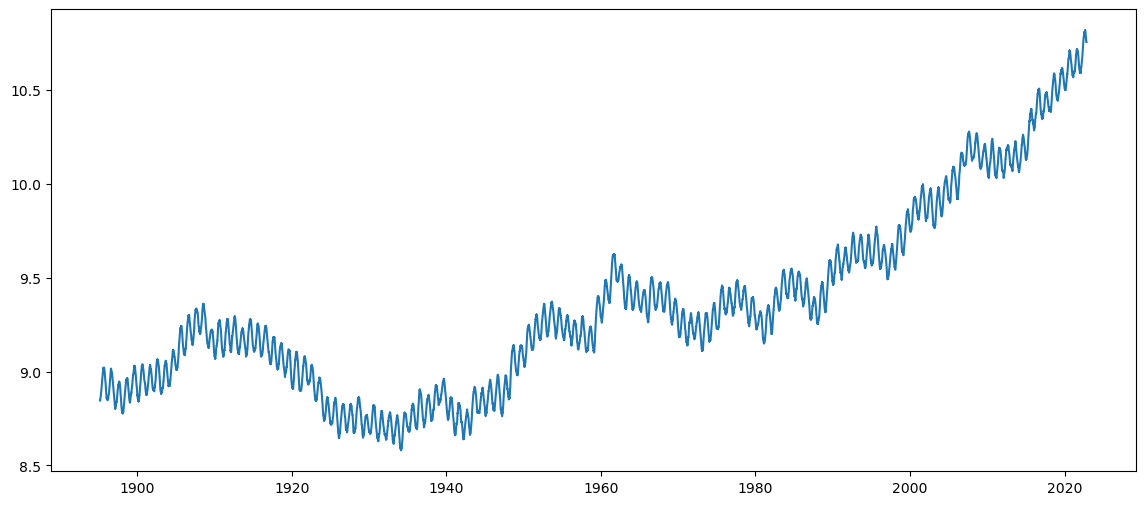

In [10]:
for index, missing_val in df[df['TG'].isnull()].iterrows():
    miss_m1_DATE = missing_val['DATE'] - pd.DateOffset(years=1) # get DATE from a year before
    miss_p1_DATE = missing_val['DATE'] + pd.DateOffset(years=1) # get DATE from a year after
    temp_m1 = df[df['DATE']==miss_m1_DATE]['TG'].values # get the temp for that year and save it in a value
    temp_p1 = df[df['DATE']==miss_p1_DATE]['TG'].values
    # geh an die stelle von DATE, dass missingvals gleicht und füg in TG den mean ein.
    df.loc[df['DATE'] == missing_val['DATE'],'TG'] = (temp_m1+temp_p1)/2
    
plt.plot(df['DATE'], df['TG'].rolling(7000).mean()) # Rolling takes average(the number of data point taken average per point is goiven by number)

##### Date to datetime (and set to index)

In [11]:
df.set_index('DATE', inplace=True)
df.head(1)
#df.reset_index(inplace=True) to repeat command you should reset and set again

,TG
DATE,
1876-01-01,2.2


##### Extracted month and year

In [12]:
df['year']=df.index.year
df['month']=df.index.month_name()

##### create timestep alternative representation of dates(for trend)

In [13]:
df['time_step'] = list(range(len(df)))
df.tail(1) #50.= 2022-09-12

,TG,year,month,time_step
DATE,,,,
2022-10-31,12.9,2022,October,53629


### Train-Test Split

In [14]:
df.shape

(53630, 4)

In [15]:
df.tail(1)

,TG,year,month,time_step
DATE,,,,
2022-10-31,12.9,2022,October,53629


In [16]:
df_train = df.loc[:'2021-10-31']
df_test = df.loc['2021-11-01':]

In [17]:
# Check that train and data has subsequent days, no mismatching. Which could cause big problems!
print(df_train.head(1), df_train.tail(1), df_test.head(1), df_test.tail(1))

             TG  year    month  time_step
DATE                                     
1876-01-01  2.2  1876  January          0               TG  year    month  time_step
DATE                                      
2021-10-31  13.4  2021  October      53264               TG  year     month  time_step
DATE                                       
2021-11-01  10.4  2021  November      53265               TG  year    month  time_step
DATE                                      
2022-10-31  12.9  2022  October      53629


## Modelling

#### Model for Trend

/tmp/ipykernel_14512/1372859122.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend'] = m_trend.predict(X)


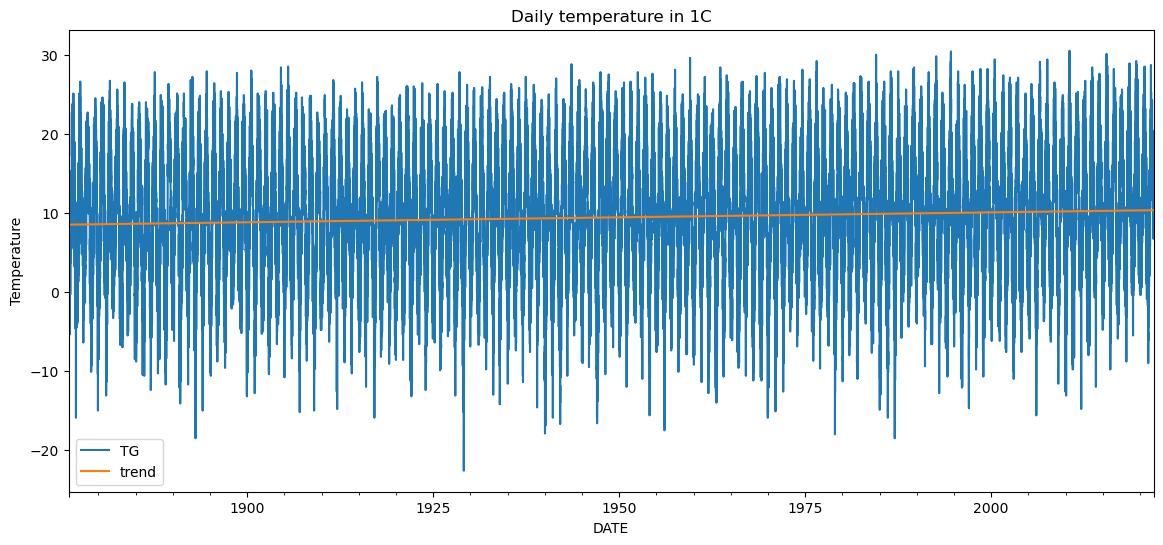

In [18]:
#4: Run a Linear Regression for trend
m_trend = LinearRegression()
X = df_train[['time_step']]   # X = flights[['year']] or X = flights[['month']] ----> Gave us a stepwise function without any obvious trend over time; not exactly what we wanted
y = df_train['TG']
m_trend.fit(X, y)
df_train['trend'] = m_trend.predict(X)

#Plot trend and original data
plot_graph(df_train[['TG', 'trend']])

#### Model Trend & Seasonality in one L.Reg

In [19]:
#5: Model the seasonability: one-hot encode the months
df_train = pd.get_dummies(df_train, prefix='', prefix_sep='')
df_train.head(1)

,TG,year,time_step,trend,April,August,December,February,January,July,June,March,May,November,October,September
DATE,,,,,,,,,,,,,,,,
1876-01-01,2.2,1876,0,8.510645,0,0,0,0,1,0,0,0,0,0,0,0


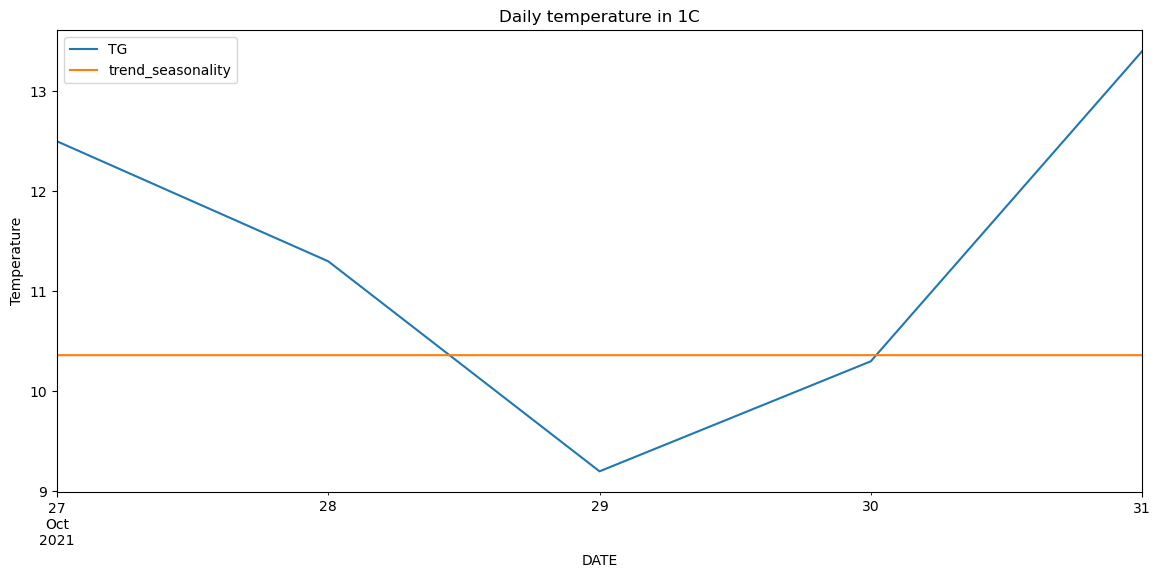

In [20]:
m_tred_season= LinearRegression()
X = df_train.drop(columns=['year','trend','TG'])   # X = flights[['year']] or X = flights[['month']] ----> Gave us a stepwise function without any obvious trend over time; not exactly what we wanted
y = df_train['TG']
m_tred_season.fit(X, y)
df_train['trend_seasonality'] = m_tred_season.predict(X)

#Plot trend and original data
df2=df_train.loc['2021-10-27':'2022-10-27']
plot_graph(df2[['TG', 'trend_seasonality']])

In [21]:
df

,TG,year,month,time_step
DATE,,,,
1876-01-01,2.2,1876,January,0
1876-01-02,2.5,1876,January,1
1876-01-03,0.3,1876,January,2
1876-01-04,-5.8,1876,January,3
1876-01-05,-9.8,1876,January,4
...,...,...,...,...
2022-10-27,14.7,2022,October,53625
2022-10-28,17.0,2022,October,53626
2022-10-29,16.9,2022,October,53627


#### Extract the reminder

In [22]:
df_train['remainder']=df_train['TG']-df_train['trend_seasonality']

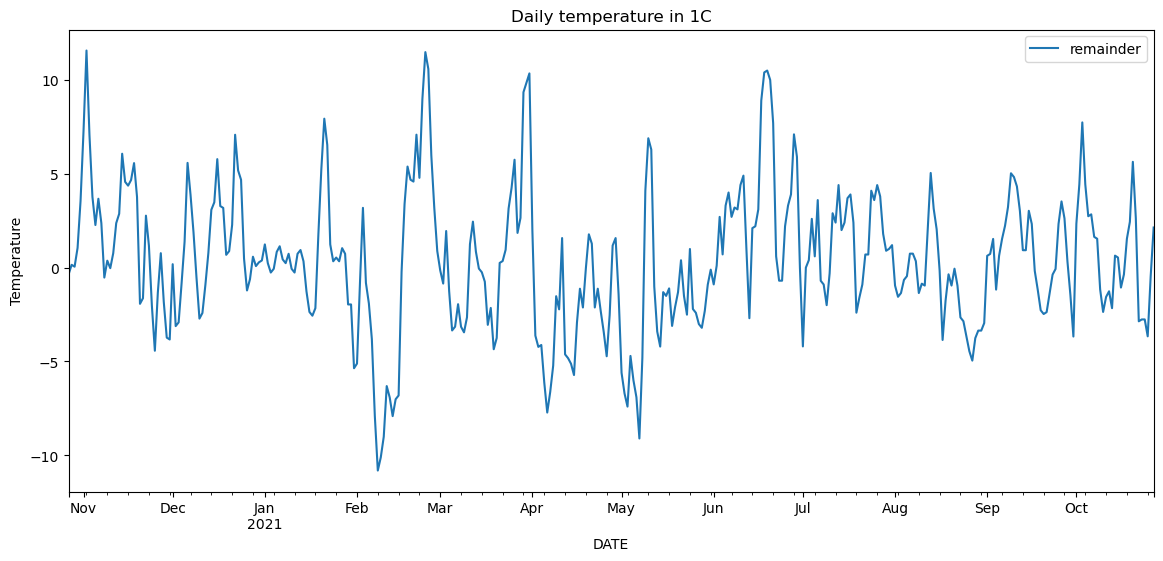

In [23]:
df2=df_train.loc['2020-10-27':'2021-10-27']
#plot_graph(df2[['TG','trend_seasonality','remainder']])
plot_graph(df2[['remainder']])

In [24]:
# Save Remainder to csv file
df_train['remainder'].to_csv('TG_remainder.csv')

In [25]:
#